In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import balanced_accuracy_score,f1_score,precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score


In [2]:
BASE_PATH = 'data/ROSMAP/'
methy_path = os.path.join(BASE_PATH,'methy.csv')
mirna_path = os.path.join(BASE_PATH,'mirna.csv')
mrna_path = os.path.join(BASE_PATH,'mrna.csv')
if not os.path.exists(methy_path) or not os.path.exists(mirna_path) or not os.path.exists(mrna_path):
    raise Exception('File not exists!')

In [3]:
methy_df = pd.read_csv(methy_path, index_col=0)
mirna_df = pd.read_csv(mirna_path, index_col=0)
mrna_df = pd.read_csv(mrna_path, index_col=0)
print(methy_df.shape, mirna_df.shape, mrna_df.shape)

(351, 202) (351, 202) (351, 202)


In [4]:
methy_df_wol = methy_df.drop('Label', axis=1)
mirna_df_wol = mirna_df.drop('Label', axis=1)
mrna_df_wol = mrna_df.drop('Label', axis=1)
methy_df_wos = methy_df_wol.drop('Split', axis=1)
mirna_df_wos = mirna_df_wol.drop('Split', axis=1)
mrna_df_wos = mrna_df_wol.drop('Split', axis=1)

combined_df = pd.concat([methy_df_wos, mirna_df_wos, mrna_df_wos], axis=1)
combined_df['Label'] = methy_df['Label']
combined_df['Split'] = methy_df['Split']

In [5]:
def get_train_test(df):
    train_df = df[df['Split'] == 1].drop('Split', axis=1)
    test_df = df[df['Split'] == 0].drop('Split', axis=1)
    y_train = train_df.pop('Label')
    y_test = test_df.pop('Label')
    return train_df, test_df, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = get_train_test(combined_df)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((245, 600), (106, 600), (245,), (106,))

In [8]:
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

In [9]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train_scaled, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_test_scaled)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

/home/dhakal/anaconda3/envs/ADomics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/dhakal/anaconda3/envs/ADomics/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/dhakal/anaconda3/envs/ADomics/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.792453,0.800000,0.800000
Support Vector Machines,0.792453,0.818182,0.789474
Decision Trees,0.641509,0.600000,0.673469
Random Forest,0.773585,0.781818,0.781818
Naive Bayes,0.792453,0.745455,0.836735
K-Nearest Neighbor,0.679245,0.636364,0.714286


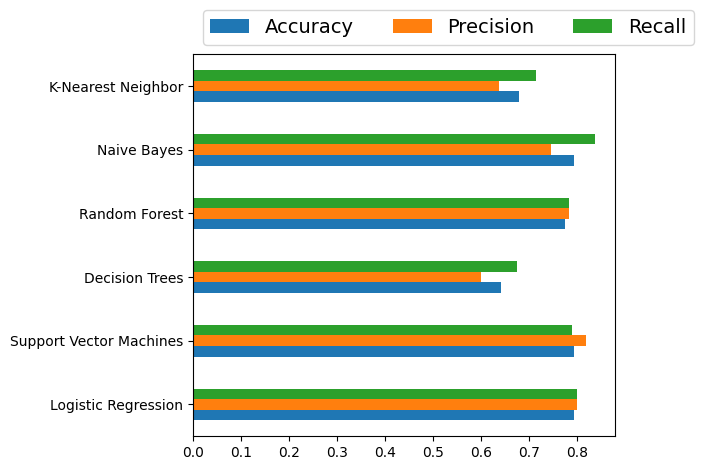

In [12]:
ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()), 
    bbox_to_anchor=(0, 1), 
    loc='lower left', 
    prop={'size': 14}
)
plt.tight_layout()